# Predicción del abandono (burnout) de empleados en una empresa
### Paulo Álvarez Da Costa. NIA: 100475757

### Configuraciones iniciales 

In [48]:
# Importaciones necesarias para el desarrollo de la practica
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


# Constantes usadas durante el desarrollo de la practica
SEED = 100475757 # La semilla es mi NIA 
employees_ava = pd.read_csv("DATA/employee_availabledata.csv")
numeric_employees_ava = employees_ava.select_dtypes(include=[np.number]) # Seleccion de las columnas numericas

## EDA 

Antes de nada, voy a comenzar con un análisis de la database para entender mejor la estructura que sigue. Se presentan las siguientes acciones:

1. **Visualización de las primeras filas:** Para obtener una idea general de la estructura del dataset.
2. **Tipos de datos por columna:** Para identificar si las variables son categóricas, numéricas o de otro tipo.
3. **Valores nulos:** Para analizar la cantidad de valores faltantes en cada columna.
4. **Columnas con valores únicos:** Para detectar variables que tienen un solo valor en todo el conjunto de datos, lo que puede indicar redundancia.



In [49]:
# Primeras filas del DataFrame
print("Primeras filas:")
display(employees_ava.head())

# Tipos de datos de cada columna
print("\nTIPOS DE DATOS:")
print(employees_ava.dtypes)

# Valores nulos en cada columna
print("\nVALORES NULOS POR COLUMNA:")
display(employees_ava.isnull().sum())

# Columnas que solo tienen valores únicos
unique_columns = employees_ava.columns[employees_ava.nunique() == 1].tolist()
print("\nColumnas con valores únicos:")
print(unique_columns)

employees_ava.info() 

Primeras filas:


,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,...,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,6.711397,17,2,3,3.0,3.0,4.0,45,Non-Travel,Sales,...,Y,15,8,0,10.0,3,8,5,7,No
1,6.433872,13,3,3,3.0,3.0,3.0,30,Travel_Rarely,Research & Development,...,Y,18,8,1,10.0,3,7,1,7,No
2,8.590515,15,3,3,4.0,3.0,3.0,43,Travel_Frequently,Sales,...,Y,11,8,1,10.0,5,8,4,7,No
3,6.888548,21,3,4,4.0,3.0,3.0,26,Travel_Rarely,Research & Development,...,Y,20,8,0,5.0,3,4,0,0,No
4,6.308825,11,3,3,2.0,1.0,2.0,42,Travel_Rarely,Research & Development,...,Y,11,8,0,10.0,2,0,0,0,No



TIPOS DE DATOS:
hrs                        float64
absences                     int64
JobInvolvement               int64
PerformanceRating            int64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                          int64
BusinessTravel              object
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeID                   int64
Gender                      object
JobLevel                     int64
JobRole                     object
MaritalStatus               object
MonthlyIncome                int64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike            int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany               int64
Yea

hrs                         0
absences                    0
JobInvolvement              0
PerformanceRating           0
EnvironmentSatisfaction    18
JobSatisfaction            14
WorkLifeBalance            20
Age                         0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         10
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
Attrition                   0
dtype: int64


Columnas con valores únicos:
['EmployeeCount', 'Over18', 'StandardHours']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      2940 non-null   float64
 1   absences                 2940 non-null   int64  
 2   JobInvolvement           2940 non-null   int64  
 3   PerformanceRating        2940 non-null   int64  
 4   EnvironmentSatisfaction  2922 non-null   float64
 5   JobSatisfaction          2926 non-null   float64
 6   WorkLifeBalance          2920 non-null   float64
 7   Age                      2940 non-null   int64  
 8   BusinessTravel           2940 non-null   object 
 9   Department               2940 non-null   object 
 10  DistanceFromHome         2940 non-null   int64  
 11  Education                2940 non-null   int64  
 12  EducationField           2940 non-null   object 
 13  Emp

Como se puede observar, existen varias columnas de la base de datos con valores nulos y algunas con un valor único en todas las filas, las cuales podrian no aportar información relevante. Además, las variables categóricas necesitarán ser codificadas en formato numérico para su correcto procesamiento. 

### Análisis de la Variable Objetivo "Attrition"

También voy a realizar un análisis de la variable objetivo "Attrition" para entender mejor su distribución en el conjunto de datos. La variable "Attrition" indica si un empleado ha dejado la empresa (yes) o no (no). Para ello, he querido realizar lo siguiente: 

1. **Contar el número de empleados en cada categoría y calcular el porcentaje correspondiente.**

2. **Mostrar un DataFrame con el conteo y el porcentaje de empleados que han dejado la empresa y los que no.**

3. **Crear un gráfico de barras para visualizar la distribución de "Attrition".**


,Count,Percentage
Attrition,,
No,2466,83.877551
Yes,474,16.122449


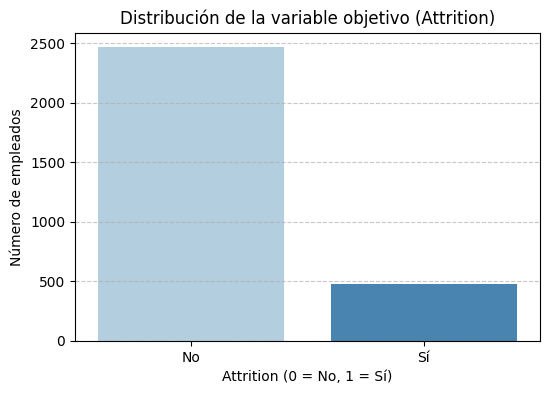

In [50]:
# Análisis de la variable objetivo "Attrition"
attrition_counts = employees_ava["Attrition"].value_counts()
attrition_percentage = employees_ava["Attrition"].value_counts(normalize=True) * 100
attrition_summary = pd.DataFrame({"Count": attrition_counts, "Percentage": attrition_percentage})
display(attrition_summary)

# Visualización de la variable objetivo "Attrition"
plt.figure(figsize=(6,4))
sns.barplot(x=attrition_counts.index, y=attrition_counts.values, hue=attrition_counts.index, palette="Blues")
plt.title("Distribución de la variable objetivo (Attrition)")
plt.xlabel("Attrition (0 = No, 1 = Sí)")
plt.ylabel("Número de empleados")
plt.xticks([0,1], ["No", "Sí"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Se trata de un problema de clasificación en el que la variable objetivo 'Attrition' presenta un claro desbalance, con un 83.88% de empleados que no han abandonado frente a un 16.12% que sí. Este desequilibrio podría influir en el rendimiento del modelo, favoreciendo la predicción de la clase mayoritaria y dificultando la detección de los casos de abandono.

Antes de continuar, voy a realizar una limpieza de variables, eliminando las columnas con valores únicos (Over18, EmployeeCount y StandardHours) y las que no aportan información relevante (EmployeeID). 

In [51]:
# Eliminación de las columnas con valores únicos
employees_ava = employees_ava.drop(columns=unique_columns)

# Eliminación de la columna "EmployeeID"
employees_ava = employees_ava.drop(columns="EmployeeID")

# Nueva asignación de las columnas numéricas
numeric_employees_ava = employees_ava.select_dtypes(include=[np.number])

print("Columnas eliminadas: ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeID']")
print("Columnas restantes:", employees_ava.shape[1])

Columnas eliminadas: ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeID']
Columnas restantes: 27


### Búsqueda de valores Atípicos 

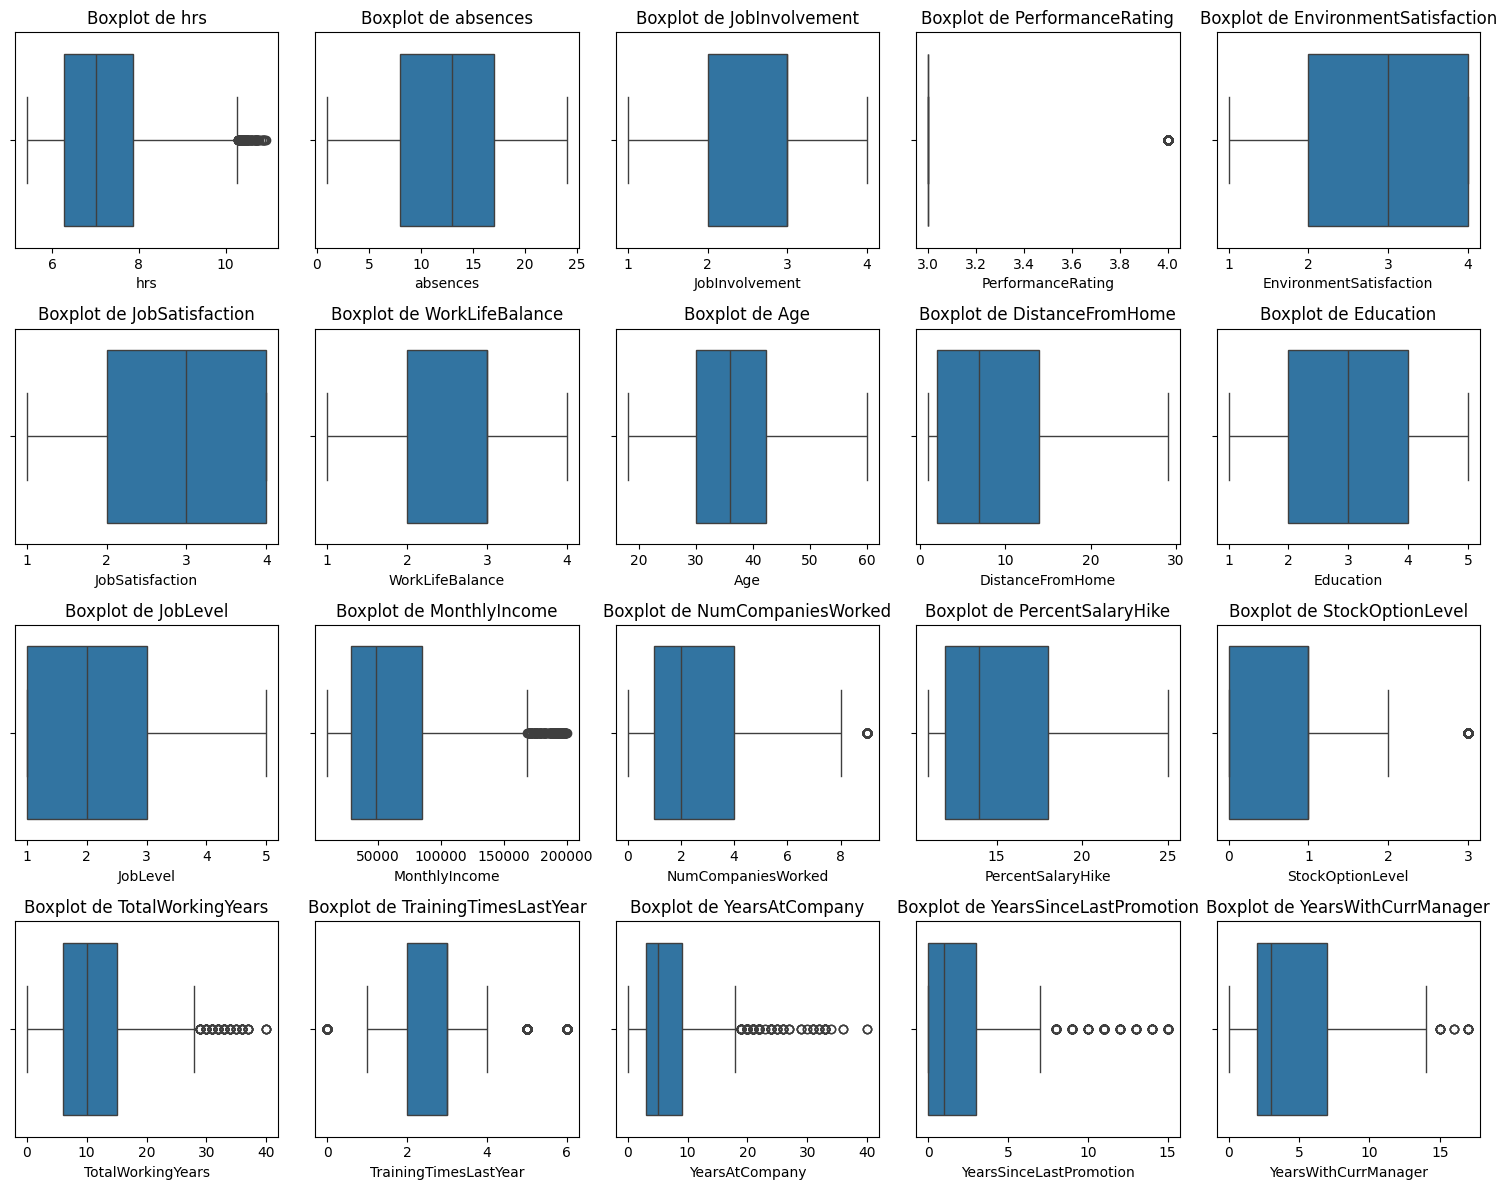

In [52]:
# Búsqueda de valores atípicos en las columnas numéricas
num_plots = len(numeric_employees_ava.columns)
num_rows = -(-num_plots // 5)  

fig, axs = plt.subplots(num_rows, 5, figsize=(15, 3*num_rows))

axs = axs.flatten() 

for i, column in enumerate(numeric_employees_ava.columns):
    sns.boxplot(x=numeric_employees_ava[column], ax=axs[i])
    axs[i].set_title(f"Boxplot de {column}")

# Ocultar ejes sobrantes
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

Como se puede observar, hay variables que cuentan con valores atípicos, ya sea porque se encuentran muy por encima o por debajo de los valores típicos como en el caso de **['hrs', 'MonthlyIncome', 'TotalWorkingYears',   'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']** o porque existe una gran mayoría de valores en un mismo número, lo que hace que el resto de valores sean considerados atípicos, aunque la diferencia no sea tan grande como en el caso anterior. Es el caso de **['PerformanceRating', 'NumCompaniesWorked', 'StockOptionLevel']**.

### Matriz de correlación general 

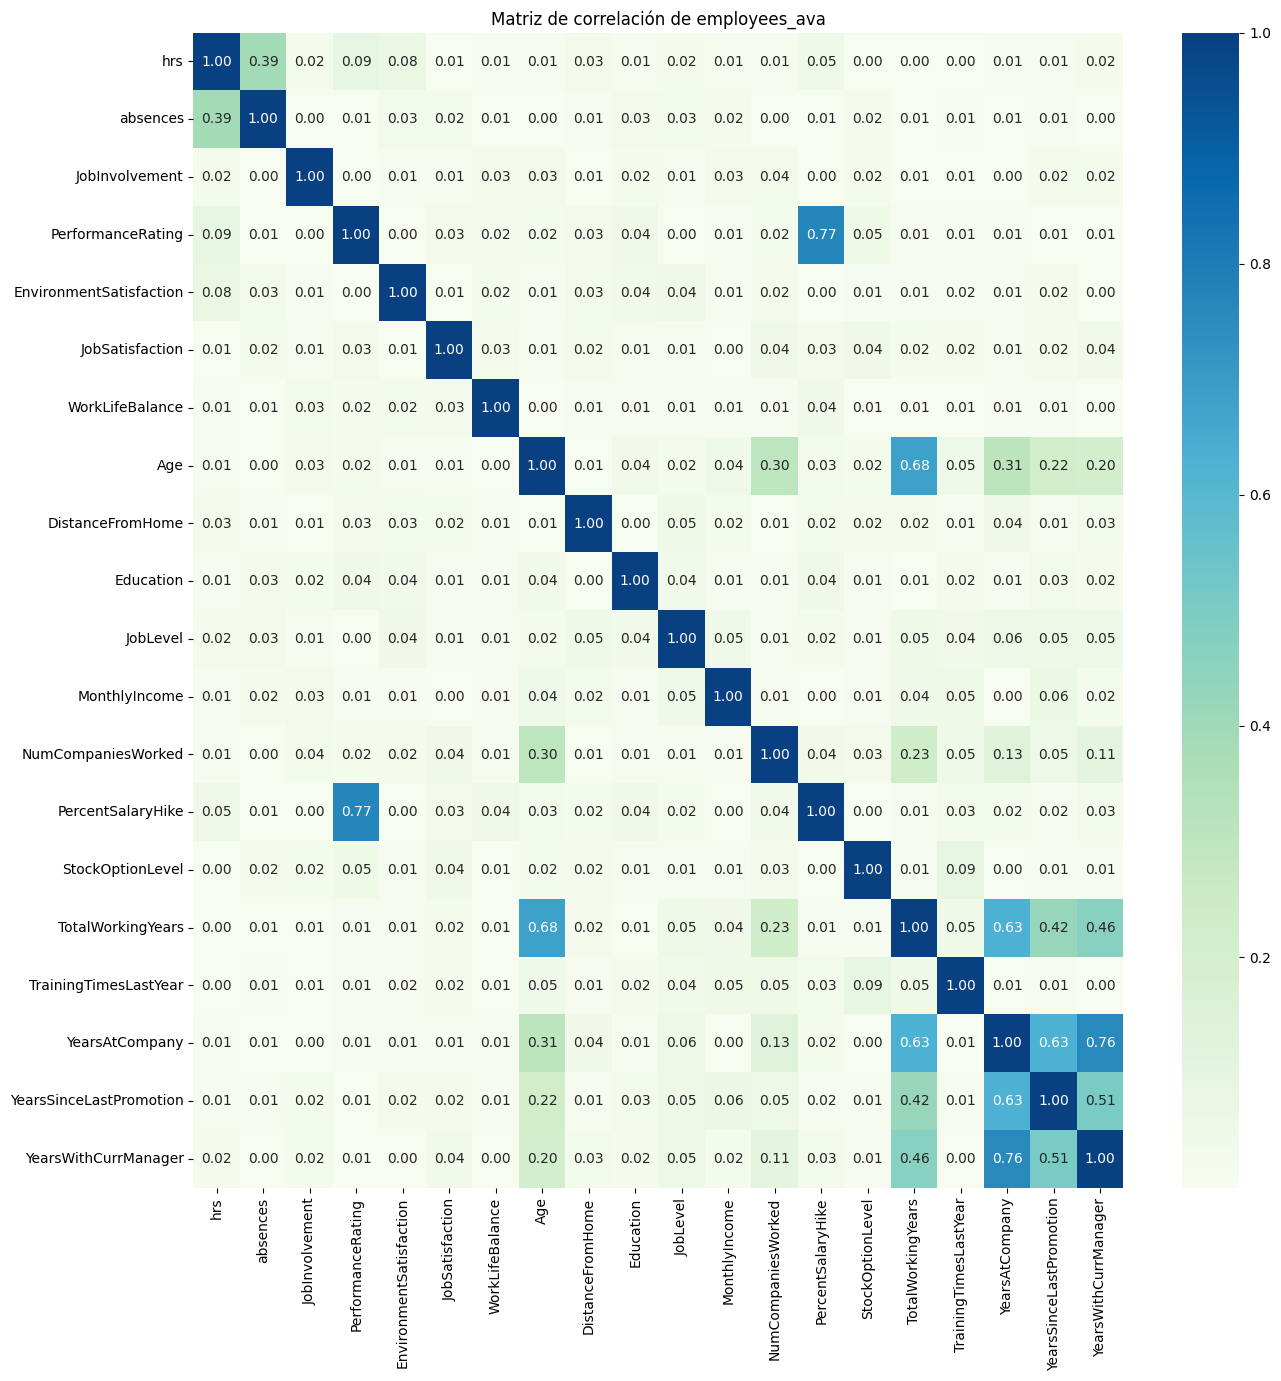

In [53]:
# Matriz de correlación de variables numéricas
correlation = numeric_employees_ava.corr()
correlation = correlation.abs()

# Visualización de la matriz de correlación
plt.figure(figsize=(15, 15))
sns.heatmap(correlation, annot=True, cmap="GnBu", fmt=".2f")
plt.title("Matriz de correlación de employees_ava")
plt.show()

Como se puede observar, no existe una correlación muy fuerte entre las variables independientes, lo que puede indicar que aportan información relevante para el modelo. La correlación más alta se encuentra entre **'PerformanceRating'** y **'PercentSalaryHike'** con un valor de 0.77, lo que podría indicar cierta multicolinealidad entre estas variables. Además, solo se está analizando la correlación de variables numéricas, por lo tanto, no veo posible reducir la dimensionalidad del problema y voy a continuar sin eliminar ninguna variable. 

## Métodos de Evaluación (Inner y Outer)

#### Pipelines

Antes de continuar, voy a realizar el preprocesamiento y optimización de los datos, transformando las variables categóricas a numéricas a través de **OneHotEncoding**. En el caso de las columnas numéricas en las que hay valores nulos, voy a imputar la mediana de cada columna, ya que es robusta frente a valores atípicos (outliers), lo que significa que si la variable tiene datos extremos, la mediana no se verá afectada tanto como la media. Gracias a esto la imputación no distorsiona la distribución original de la variable.

In [54]:
# Convertir la variable objetivo 'Attrition' a binaria: 1 para "Yes", 0 para "No"
employees_ava['Attrition'] = employees_ava['Attrition'].map({'Yes': 1, 'No': 0})

# Separar las features y la variable objetivo
X = employees_ava.drop(columns=['Attrition'])
y = employees_ava['Attrition']

# Selección de las columnas categóricas y numéricas del Dataset X
categorical_columns = X.select_dtypes(include=["object"]).columns.tolist()
numeric_columns = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Pipeline para transformar las variables categóricas
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  
])

# Pipeline para transformar las variables numéricas
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', RobustScaler())                      
])

# Combinar ambos pipelines en un ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

# Aplicar el preprocesamiento a las features
X_preprocessed = preprocessor.fit_transform(X)

print("Forma de los datos preprocesados:", X_preprocessed.shape)

Forma de los datos preprocesados: (2940, 46)


Voy a comenzar dividiendo el conjunto de datos en dos partes: un conjunto de entrenamiento (2/3 de los datos) y un conjunto de prueba (1/3 de los datos) escogidos de forma aleatoria usando como semilla mi NIA. El conjunto de entrenamiento se utilizará para evaluar los modelos que se verán a continuación, mientras que el conjunto de prueba se utilizará únicamente para evaluar el modelo final escogido.

In [55]:
# Dividir en 2/3 para entrenamiento y 1/3 para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=SEED, stratify=y)

# Preprocesar los conjuntos de entrenamiento y prueba
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} filas")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} filas")


Tamaño del conjunto de entrenamiento: 1960 filas
Tamaño del conjunto de prueba: 980 filas


### Evaluación Inner 

Esta es la evaluación que se aplica durante todo el proceso de exploración y ajuste de modelos, utilizando exclusivamente el conjunto de entrenamiento. Se ha implementado mediante validación cruzada con 5 folds (k=5). Esta técnica divide el conjunto de entrenamiento en cinco partes, de tal forma que el modelo se entrena cinco veces, utilizando 4/5 partes para el entrenamiento y 1/5 para la validación en cada iteración.

He escogido un k=5 porque ofrece un equilibrio adecuado entre el rendimiento de la estimación y su coste computacional. Usar un número menor de folds (como k=2 o k=3) puede generar estimaciones menos fiables, mientras que valores más altos (como k=10) aumentan considerablemente el tiempo de entrenamiento sin aportar mejoras significativas en la estimación, especialmente en conjuntos de datos de tamaño medio como el que estoy tratando.

### Evaluación Outer

La evaluación outer se reservará únicamente para el final, cuando se haya seleccionado la mejor alternativa. En ese momento, se evaluará el modelo final sobre el conjunto de prueba (test set), obteniendo así una estimación realista de su rendimiento futuro.

### Modelo Dummy

Antes de continuar con el siguiente apartado, voy a crear un modelo Dummy para establecer una línea base de comparación. Este modelo se basa en la predicción de la clase mayoritaria, es decir, siempre predice que el empleado no ha abandonado la empresa. Esto me permitirá evaluar si los modelos que voy a implementar son capaces de superar esta línea base.

,Balanced Accuracy,Accuracy
Dummy Classifier,0.5,0.838776


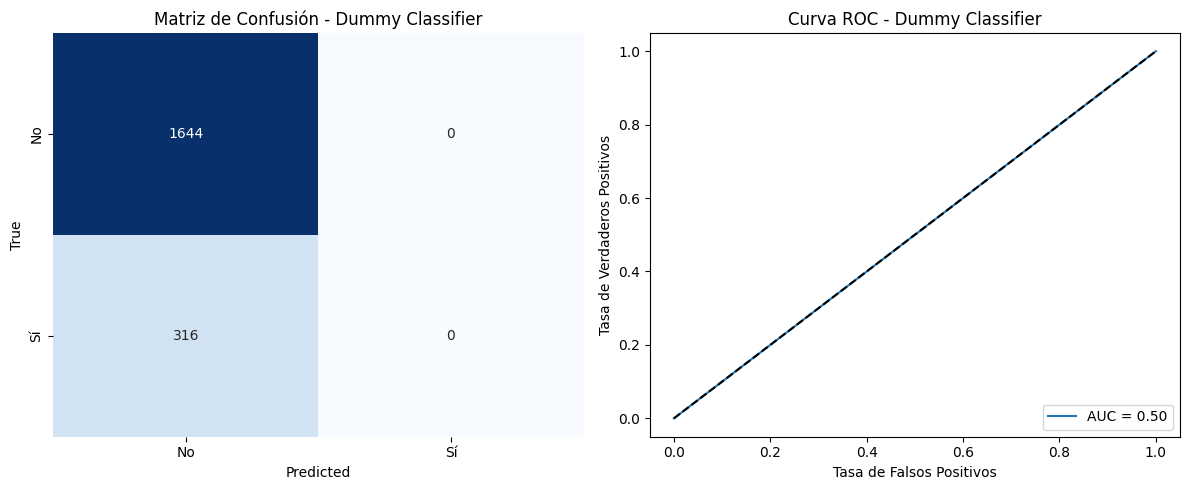

In [56]:
# Evaluar el modelo Dummy con validación cruzada (inner)
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=SEED)

# Validación cruzada (5 folds) en el conjunto de entrenamiento
cv_balanced_accuracy_dummy = cross_val_score(dummy_clf, X_train, y_train, cv=5, scoring='balanced_accuracy')
cv_accuracy_dummy = cross_val_score(dummy_clf, X_train, y_train, cv=5, scoring='accuracy')

# Resultados promedio de la validación cruzada
mean_balanced_accuracy_dummy = cv_balanced_accuracy_dummy.mean()
mean_accuracy_dummy = cv_accuracy_dummy.mean()

# Entrenar el modelo Dummy y calcular la curva ROC
dummy_clf.fit(X_train, y_train)
y_prob_dummy = dummy_clf.predict_proba(X_train)[:, 1]

# Calcular la curva ROC
fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_train, y_prob_dummy)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)

# Mostrar los resultados en un DataFrame
dummy_results = pd.DataFrame({
    'Balanced Accuracy': [mean_balanced_accuracy_dummy],
    'Accuracy': [mean_accuracy_dummy]
}, index=['Dummy Classifier'])

display(dummy_results)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

# Matriz de confusión
y_pred_dummy = cross_val_predict(dummy_clf, X_train, y_train, cv=5)
cm_dummy = confusion_matrix(y_train, y_pred_dummy)
sns.heatmap(cm_dummy, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title("Matriz de Confusión - Dummy Classifier")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_xticks([0.5, 1.5])
axes[0].set_xticklabels(["No", "Sí"])
axes[0].set_yticks([0.5, 1.5])
axes[0].set_yticklabels(["No", "Sí"])

# Curva ROC
axes[1].plot(fpr_dummy, tpr_dummy, label=f'AUC = {roc_auc_dummy:.2f}')
axes[1].plot([0, 1], [0, 1], 'k--')  # Línea diagonal
axes[1].set_title("Curva ROC - Dummy Classifier")
axes[1].set_xlabel("Tasa de Falsos Positivos")
axes[1].set_ylabel("Tasa de Verdaderos Positivos")
axes[1].legend(loc='lower right')
plt.tight_layout()
plt.show()

Como se puede observar, en el modelo Dummy hay 1644 verdaderos negativos y 316 falsos negativos, sin ningún verdadero positivo. El modelo identifica correctamente a todos los empleados que no abandonan (TNR = 1.0) y falla completamente en detectar a aquellos que sí abandonan (TPR = 0.0). Su balanced_accuracy de 0.5 (la media de (TNR + TPR)) indica que este modelo no es mejor que una clasificación aleatoria (como se observa en la curva ROC) y sus métricas indican claramente que no aporta información útil para la detección de la variable objetivo 'Attrition'. Por lo tanto, cumple con el objetivo de ser un modelo dummy.

## Métodos de escalado e imputación con KNN

En este apartado, voy a comenzar evaluando el impacto de diferentes técnicas de escalado e imputación en el rendimiento del modelo KNN. El objetivo, es identificar la combinación óptima de preprocesamiento que permita a este modelo alcanzar su máximo potencial, asegurando al mismo tiempo que el pipeline sea robusto frente a datos faltantes y a los diferentes rangos de valores de las variables.

,Escalado,Imputación,Mean Balanced Accuracy,Training Time
0,MinMaxScaler,mean,0.601280,0.123502
1,MinMaxScaler,median,0.601280,0.148466
2,StandardScaler,mean,0.589577,0.109080
3,StandardScaler,median,0.589577,0.139073
4,RobustScaler,mean,0.581464,0.177481
5,RobustScaler,median,0.581464,0.196744


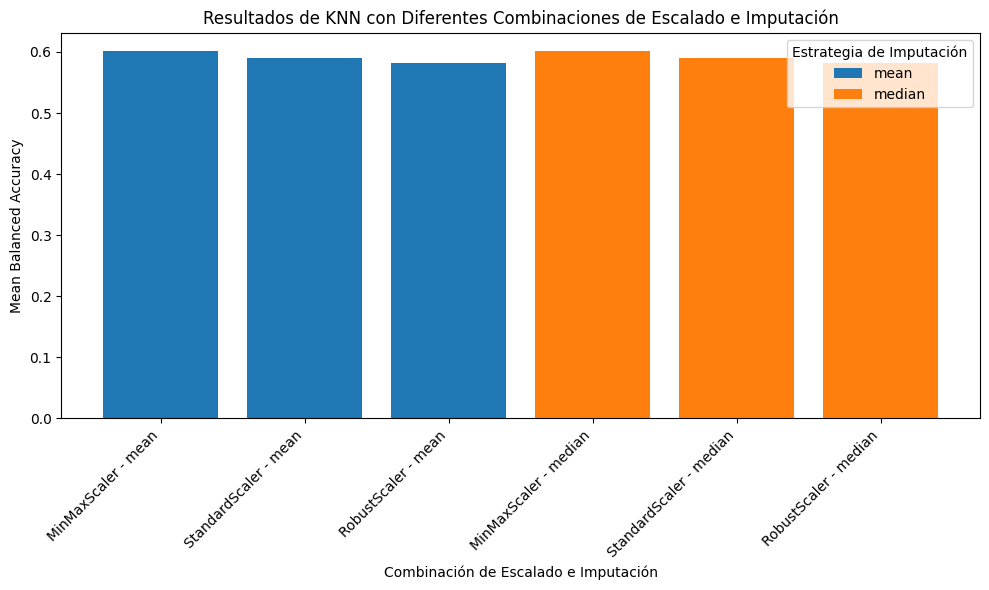

In [57]:
# Lista de métodos de escalado y de imputación
scalers = [MinMaxScaler(), StandardScaler(), RobustScaler()]
imputers = [SimpleImputer(strategy='mean'), SimpleImputer(strategy='median')]

results_knn = []

for scaler in scalers:
    for imputer in imputers:
        # Pipeline para KNN
        pipeline_knn = Pipeline([
            ('imputer', imputer),
            ('scaler', scaler),
            ('knn', KNeighborsClassifier())
        ])
        
        # Tiempo de entrenamiento y validación cruzada
        start_time = time.time()
        scores = cross_val_score(pipeline_knn, X_train, y_train, cv=5, scoring='balanced_accuracy')
        end_time = time.time()

        results_knn.append({
            'Escalado': scaler.__class__.__name__,
            'Imputación': imputer.strategy,
            'Mean Balanced Accuracy': scores.mean(),
            'Training Time': end_time - start_time
        })

# Graficos de los resultados obtenidos
results_knn_df = pd.DataFrame(results_knn)
display(results_knn_df)
plt.figure(figsize=(10, 6))
for strategy in results_knn_df['Imputación'].unique():
    subset = results_knn_df[results_knn_df['Imputación'] == strategy]
    plt.bar(subset['Escalado'] + ' - ' + strategy, subset['Mean Balanced Accuracy'], label=strategy)

plt.xlabel('Combinación de Escalado e Imputación')
plt.ylabel('Mean Balanced Accuracy')
plt.title('Resultados de KNN con Diferentes Combinaciones de Escalado e Imputación')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Estrategia de Imputación')
plt.tight_layout()
plt.show()

Como se puede observar, la combinación óptima para este problema es MinMaxScaler junto con imputación por media, ya que alcanza la mayor balanced accuracy (0.6013) manteniendo un coste computacional bajo, lo que indica una mejor capacidad para clasificar correctamente tanto a empleados que abandonan como a los que no. 

La ausencia de diferencias significativas entre la imputación por media y por mediana se debe a que las variables numéricas del conjunto de datos carecen de outliers extremos. Esto también explica por qué el uso de RobustScaler, diseñado específicamente para manejar outliers, no ha aportado mejoras en el rendimiento en este caso.

### Evaluacion de los modelos con los parámetros por defecto

A continuación, voy a evaluar los modelos 'DecisionTreeClassifier', 'KNN' y 'RandomForest' con sus parámetros por defecto para obtener una idea general de su rendimiento. Esto me permitirá identificar cuál de ellos tiene un mejor rendimiento inicial y si alguno de ellos supera la línea base establecida por el modelo Dummy. 

In [58]:
# KNN con hiperparámetros por omisión

pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())  
])

# CV para KNN
start_knn = time.time()

bal_acc_knn = cross_val_score(pipeline_knn, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()
acc_knn = cross_val_score(pipeline_knn, X_train, y_train, cv=5, scoring='accuracy').mean()

end_knn = time.time()

# --------------------------------------------------------------------------------------------------------------------

# Árbol de decisión con hiperparámetros por omisión

pipeline_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  
    ('tree', DecisionTreeClassifier(random_state=SEED))  
])

# CV para el árbol de decisión
start_tree = time.time()

bal_acc_tree = cross_val_score(pipeline_tree, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()
acc_tree = cross_val_score(pipeline_tree, X_train, y_train, cv=5, scoring='accuracy').mean()

end_tree = time.time()

# --------------------------------------------------------------------------------------------------------------------

# RandomForest con hiperparámetros por omisión

pipeline_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('rf', RandomForestClassifier(random_state=SEED))  
])

# CV para RandomForest
start_rf = time.time()

bal_acc_rf = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()
acc_rf = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='accuracy').mean()

end_rf = time.time()

# Tiempo de entrenamiento
knn_time = end_knn - start_knn
tree_time = end_tree - start_tree
rf_time = end_rf - start_rf

# ----------------------------------------------------------------------------------------------------

# Crear un DataFrame con los resultados

results = pd.DataFrame({
    "Balanced Accuracy": [bal_acc_knn, bal_acc_tree, bal_acc_rf],
    "Accuracy": [acc_knn, acc_tree, acc_rf],
    "Training Time": [knn_time, tree_time, rf_time]
}, index=["KNN", "Árbol de Decisión", "Random Forest"])

display(results)

,Balanced Accuracy,Accuracy,Training Time
KNN,0.601280,0.841327,0.252229
Árbol de Decisión,0.809519,0.892857,0.439175
Random Forest,0.788268,0.930102,6.311737


### Evaluacion de los modelos con los hiperparametros ajustados
Ahora, voy a ajustar los hiperparámetros de los modelos 'KNN', 'DecisionTreeClassifier' y 'RandomForest' con el objetivo de mejorar su rendimiento. Para ello, he utilizado la técnica de búsqueda en cuadrícula (GridSearchCV) combinada con validación cruzada de 5 folds (k=5), lo que permite identificar la mejor combinación de hiperparámetros para cada modelo.
#### KNN

In [59]:
# Pipeline para preprocesar e incluir el modelo
pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

# Espacio de búsqueda de hiperparámetros
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

# GridSearchCV
grid_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Medir tiempo de entrenamiento
start_time = time.time()
grid_knn.fit(X_train, y_train)
end_time = time.time()

# Resultados finales del GridSearchCV
best_knn = grid_knn.best_estimator_

# Métricas
bal_knn_hpo = grid_knn.best_score_  
acc_knn_hpo = cross_val_score(best_knn, X_train, y_train, cv=5, scoring='accuracy').mean() 

# Tiempo de entrenamiento
knn_time_hpo = end_time - start_time


print("KNN optimizado")
print(f"Mejores hiperparámetros: {grid_knn.best_params_}")
print(f"Balanced Accuracy (CV): {bal_knn_hpo:.4f}")
print(f"Accuracy (CV): {acc_knn_hpo:.4f}")
print(f"Tiempo de entrenamiento con HPO: {knn_time_hpo:.4f} segundos")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
KNN optimizado
Mejores hiperparámetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Balanced Accuracy (CV): 0.8187
Accuracy (CV): 0.9255
Tiempo de entrenamiento con HPO: 5.7949 segundos


#### DecisionTreeClassifier

In [60]:
# Pipeline: solo imputación (los árboles no necesitan escalado)
pipeline_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('tree', DecisionTreeClassifier(random_state=SEED))
])

# Espacio de búsqueda de hiperparámetros
param_grid_tree = {
    'tree__max_depth': [5, 10, 15, 20, None],
    'tree__min_samples_split': [2, 5, 10],
    'tree__min_samples_leaf': [1, 2, 4]
}

# GridSearchCV
grid_tree = GridSearchCV(
    estimator=pipeline_tree,
    param_grid=param_grid_tree,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Medir tiempo de entrenamiento
start_time = time.time()
grid_tree.fit(X_train, y_train)
end_time = time.time()

# Resultados
best_tree = grid_tree.best_estimator_

# Métricas
bal_tree_hpo = grid_tree.best_score_  
acc_tree_hpo = cross_val_score(best_tree, X_train, y_train, cv=5, scoring='accuracy').mean()

# Tiempo de entrenamiento
tree_time_hpo = end_time - start_time

print("Árbol de decisión optimizado")
print(f"Mejores hiperparámetros: {grid_tree.best_params_}")
print(f"Balanced Accuracy (CV): {bal_tree_hpo:.4f}")
print(f"Accuracy (CV): {acc_tree_hpo:.4f}")
print(f"Tiempo de entrenamiento con HPO: {tree_time_hpo:.4f} segundos")


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Árbol de decisión optimizado
Mejores hiperparámetros: {'tree__max_depth': 20, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}
Balanced Accuracy (CV): 0.8095
Accuracy (CV): 0.8929
Tiempo de entrenamiento con HPO: 2.2618 segundos


#### RandomForestClassifier

In [61]:
# Pipeline con imputación y Random Forest
pipeline_rf_hpo = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('rf', RandomForestClassifier(random_state=SEED))
])

# Espacio de búsqueda
param_grid_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

# GridSearchCV
grid_rf = GridSearchCV(
    estimator=pipeline_rf_hpo,
    param_grid=param_grid_rf,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entrenamiento
start_time = time.time()
grid_rf.fit(X_train, y_train)
end_time = time.time()

# Mejores resultados
best_rf = grid_rf.best_estimator_

# Métricas
bal_rf_hpo = grid_rf.best_score_ 
acc_rf_hpo = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy').mean()  

# Tiempo de entrenamiento
rf_time_hpo = end_time - start_time

print("Random Forest optimizado")
print(f"Mejores hiperparámetros: {grid_rf.best_params_}")
print(f"Balanced Accuracy (CV): {bal_rf_hpo:.4f}")
print(f"Accuracy (CV): {acc_rf_hpo:.4f}")
print(f"Tiempo de entrenamiento con HPO: {rf_time_hpo:.4f} segundos")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest optimizado
Mejores hiperparámetros: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Balanced Accuracy (CV): 0.7914
Accuracy (CV): 0.9311
Tiempo de entrenamiento con HPO: 28.6437 segundos


Habiendo obtenido los resultados de los modelos con los hiperparametros ajustados, voy a compararlos con los resultados obtenidos con los hiperparametros por defecto para distinguir qué modelo será empleado en la predicción del abandono de empleados.

#### Represenación gráfica de los resultados obtenidos

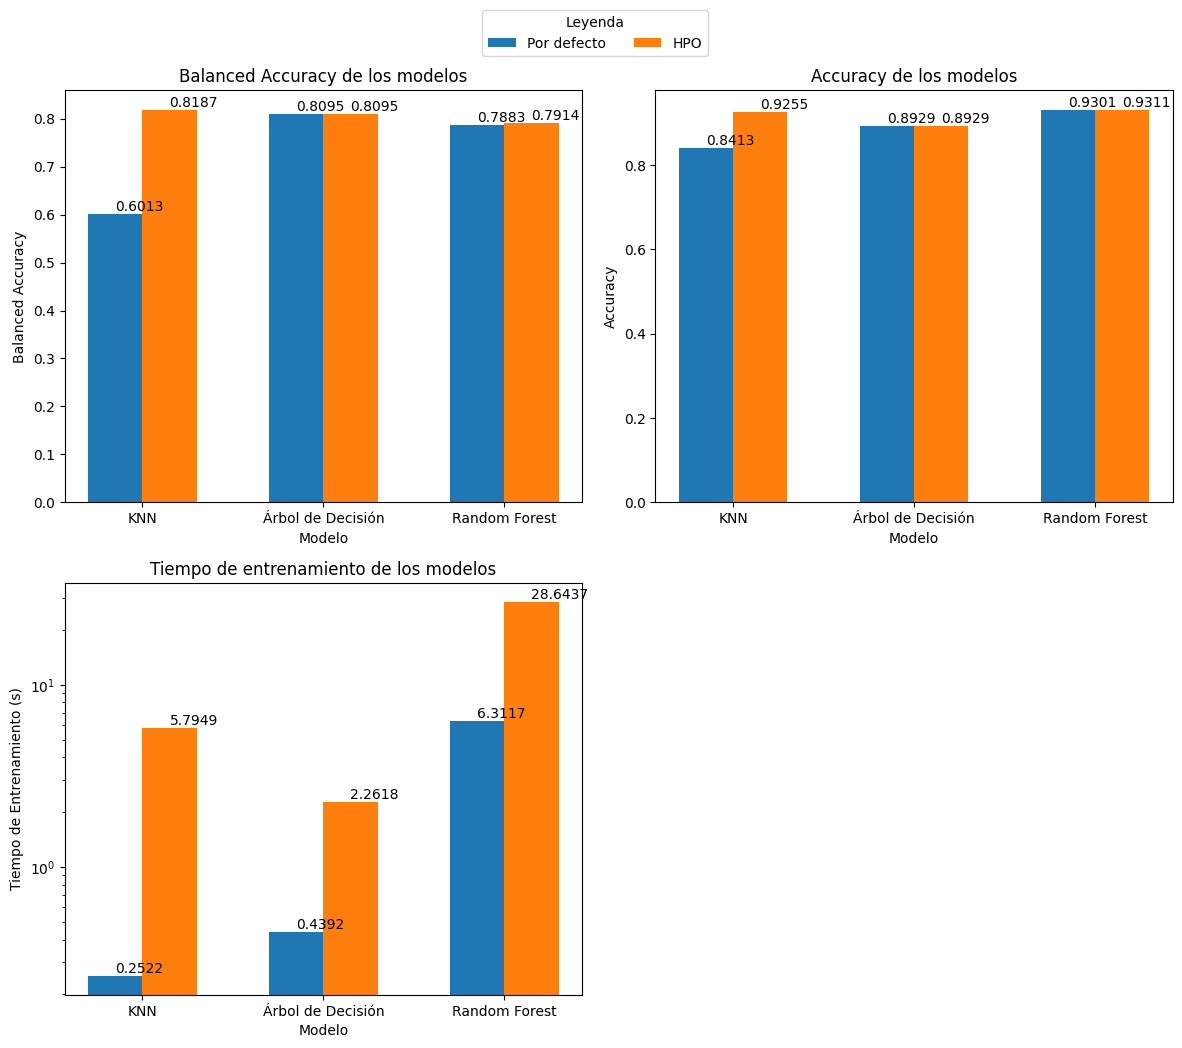

In [62]:
# Datos para Balanced Accuracy, Accuracy y tiempos de entrenamiento
balanced_accuracy = [bal_acc_knn, bal_acc_tree, bal_acc_rf]  
balanced_accuracy_hpo = [bal_knn_hpo, bal_tree_hpo, bal_rf_hpo]  
accuracy = [acc_knn, acc_tree, acc_rf]  
accuracy_hpo = [acc_knn_hpo, acc_tree_hpo, acc_rf_hpo]  
tiempos = [knn_time, tree_time, rf_time]
tiempos_hpo = [knn_time_hpo, tree_time_hpo, rf_time_hpo]

# Modelos
modelos = ['KNN', 'Árbol de Decisión', 'Random Forest']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1]})
fig.delaxes(axs[1, 1])

# -------------------------------------------------------------------------------------------------------

# Crear el gráfico de Balanced Accuracy
width = 0.30
bar_positions = np.arange(len(modelos))

# Gráfico de Balanced Accuracy
bars1 = axs[0, 0].bar(bar_positions - width/2, balanced_accuracy, width, color='#1f77b4', label='Por defecto')
bars2 = axs[0, 0].bar(bar_positions + width/2, balanced_accuracy_hpo, width, color='#ff7f0e', label='HPO')

# Añadir etiquetas a las barras
for bar in bars1:
    yval = bar.get_height()
    axs[0, 0].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')

for bar in bars2:
    yval = bar.get_height()
    axs[0, 0].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')

axs[0, 0].set_xlabel('Modelo')
axs[0, 0].set_ylabel('Balanced Accuracy')
axs[0, 0].set_title('Balanced Accuracy de los modelos')
axs[0, 0].set_xticks(bar_positions)
axs[0, 0].set_xticklabels(modelos)
axs[0, 0].set_yscale('linear')

# ------------------------------------------------------------------------------------------------------

# Gráfico de Accuracy
bars1 = axs[0, 1].bar(bar_positions - width/2, accuracy, width, color='#1f77b4', label='Por defecto')
bars2 = axs[0, 1].bar(bar_positions + width/2, accuracy_hpo, width, color='#ff7f0e', label='HPO')

# Añadir etiquetas a las barras
for bar in bars1:
    yval = bar.get_height()
    axs[0, 1].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')

for bar in bars2:
    yval = bar.get_height()
    axs[0, 1].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')

axs[0, 1].set_xlabel('Modelo')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_title('Accuracy de los modelos')
axs[0, 1].set_xticks(bar_positions)
axs[0, 1].set_xticklabels(modelos)
axs[0, 1].set_yscale('linear')

# ------------------------------------------------------------------------------------------------------

# Gráfico de Tiempo de Entrenamiento
bars1 = axs[1, 0].bar(bar_positions - width/2, tiempos, width, color='#1f77b4', label='Por defecto')
bars2 = axs[1, 0].bar(bar_positions + width/2, tiempos_hpo, width, color='#ff7f0e', label='HPO')

# Añadir etiquetas a las barras
for bar in bars1:
    yval = bar.get_height()
    axs[1, 0].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')

for bar in bars2:
    yval = bar.get_height()
    axs[1, 0].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')

axs[1, 0].set_xlabel('Modelo')
axs[1, 0].set_ylabel('Tiempo de Entrenamiento (s)')
axs[1, 0].set_title('Tiempo de entrenamiento de los modelos')
axs[1, 0].set_xticks(bar_positions)
axs[1, 0].set_xticklabels(modelos)
axs[1, 0].set_yscale('log')
fig.legend(['Por defecto', 'HPO'], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, title="Leyenda")
plt.tight_layout()
plt.show()

#### Impacto de los diferentes hiperparámetros en el rendimiento de los modelos

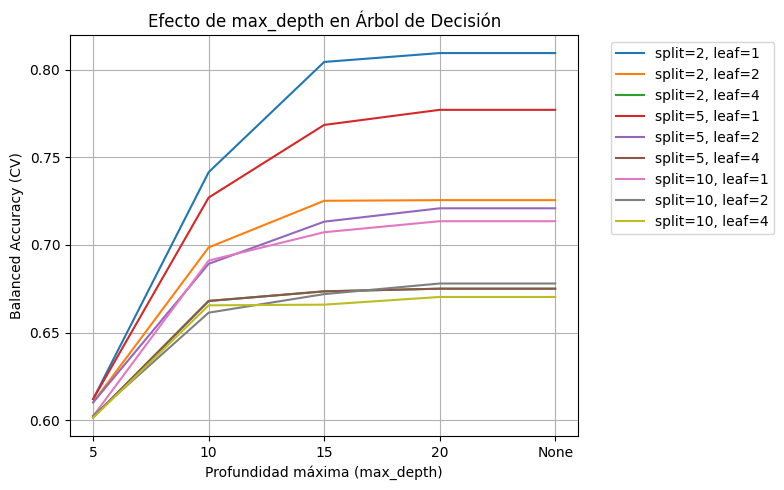

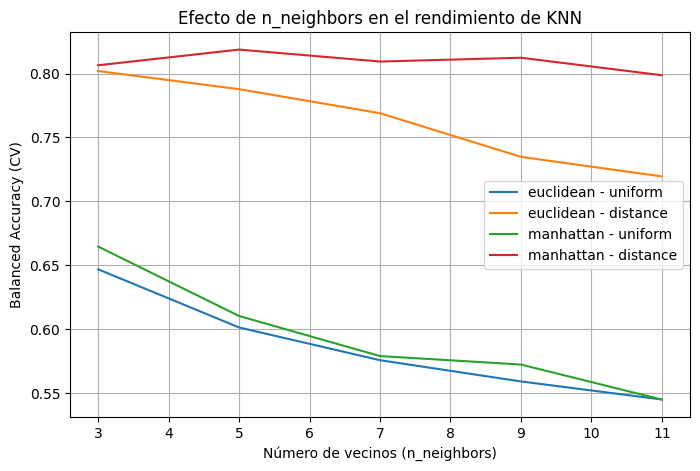

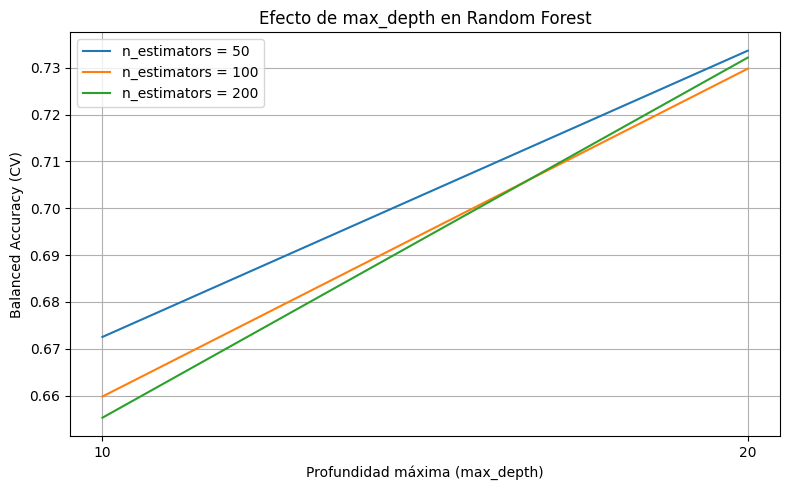

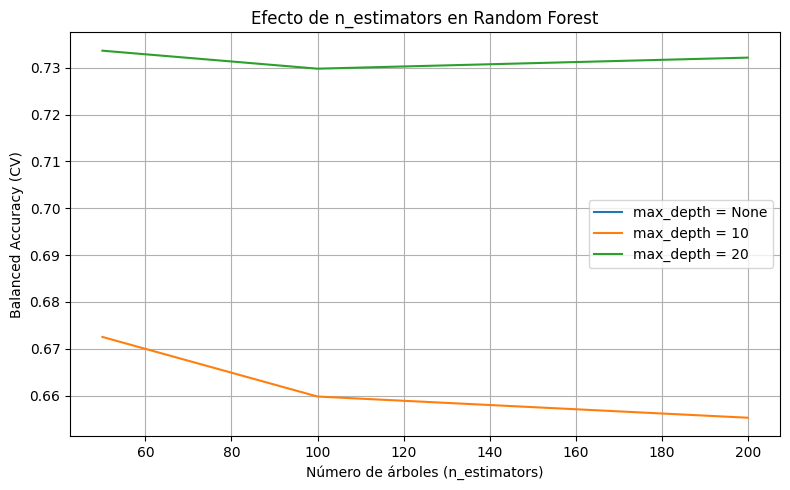

In [63]:
# Convertir los resultados de GridSearchCV para Árbol de Decisión a DataFrame
tree_results = pd.DataFrame(grid_tree.cv_results_)

# Crear el gráfico para 'max_depth'
plt.figure(figsize=(8, 5))
for split in [2, 5, 10]:
    subset = tree_results[tree_results['param_tree__min_samples_split'] == split]
    for leaf in [1, 2, 4]:
        line = subset[subset['param_tree__min_samples_leaf'] == leaf]
        plt.plot(line['param_tree__max_depth'].astype(str), line['mean_test_score'], label=f"split={split}, leaf={leaf}")

plt.xlabel('Profundidad máxima (max_depth)')
plt.ylabel('Balanced Accuracy (CV)')
plt.title('Efecto de max_depth en Árbol de Decisión')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------------------------------

# Convertir los resultados de GridSearchCV de KNN a DataFrame
knn_results = pd.DataFrame(grid_knn.cv_results_)

# Filtrar los resultados por 'metric' y 'weights'
plt.figure(figsize=(8, 5))
for metric in ['euclidean', 'manhattan']:
    subset = knn_results[knn_results['param_knn__metric'] == metric]
    for weight in ['uniform', 'distance']:
        line = subset[subset['param_knn__weights'] == weight]
        plt.plot(line['param_knn__n_neighbors'], line['mean_test_score'], label=f"{metric} - {weight}")

plt.xlabel('Número de vecinos (n_neighbors)')
plt.ylabel('Balanced Accuracy (CV)')
plt.title('Efecto de n_neighbors en el rendimiento de KNN')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------------------------------------------------

# Convertir los resultados de GridSearchCV de Random Forest a DataFrame

rf_results = pd.DataFrame(grid_rf.cv_results_)

# Gráfico: efecto de max_depth
plt.figure(figsize=(8, 5))
for n_estimators in [50, 100, 200]:
    subset = rf_results[rf_results['param_rf__n_estimators'] == n_estimators]
    line = subset.groupby('param_rf__max_depth')['mean_test_score'].mean()
    plt.plot(line.index.astype(str), line.values, label=f"n_estimators = {n_estimators}")

plt.xlabel('Profundidad máxima (max_depth)')
plt.ylabel('Balanced Accuracy (CV)')
plt.title('Efecto de max_depth en Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico: efecto de n_estimators
plt.figure(figsize=(8, 5))
for depth in [None, 10, 20]:
    subset = rf_results[rf_results['param_rf__max_depth'] == depth]
    line = subset.groupby('param_rf__n_estimators')['mean_test_score'].mean()
    plt.plot(line.index, line.values, label=f"max_depth = {depth}")

plt.xlabel('Número de árboles (n_estimators)')
plt.ylabel('Balanced Accuracy (CV)')
plt.title('Efecto de n_estimators en Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Conclusiones

- **Mejor modelo**

    Como se puede observar, el modelo que alcanza el mejor equilibrio entre rendimiento y eficiencia computacional es KNN con hiperparámetros optimizados. Logra la mejor balanced accuracy entre todos los modelos (0.82) y lo hace con un coste computacional relativamente bajo, siendo ideal para problemas como este donde importa tanto la precisión como la escalabilidad.
    Random Forest es el que peor rendimiento ofrece, además, su aumento del coste computacional no se traduce en una mejora significativa. Por otra parte, el árbol de decisión se mantiene como un modelo sólido sin necesidad de ajustes.

- **Comparación con el modelo Dummy**

    Como era de esperar, todos los modelos superan ampliamente al clasificador dummy, tanto en precisión como en capacidad para distinguir entre clases balanceadas. Estos modelos triviales son únicamente útiles como punto de referencia para comparar con otros modelos más sofisticados.

- **Impacto de la optimización de hiperparámetros**

    En cuanto al ajuste de hiperparámetros, se observa que la optimización del modelo KNN ha llevado a mejoras significativas en el rendimiento, mientras que el árbol de decisión y random forest no han mostrado cambios notables.Esto sugiere que estos últimos modelos ya estaba bien ajustado con los hiperparámetros por defecto.

- **Coste computacional**

   La mejora de rendimiento obtenida en el modelo KNN y Random Forest tras la optimización de hiperparámetros viene acompañada de un aumento en la complejidad del proceso. 
   Este incremento en la carga computacional es especialmente visible en el modelo Random Forest. Por el contrario, KNN consigue una mejora notable con un proceso de optimización más ligero, lo que lo convierte en una solución especialmente eficiente.

## Modelos lineales y SVMs

Ahora, al igual que con los métodos básicos, voy a evaluar los modelos lineales (regresión logística sin regularización y con regularización L1) y SVMs, para ver si hay alguna mejora en el rendimiento de mi modelo predictivo. Comenzaré evaluando los modelos y SVMs con sus hiperparámetros por defecto y luego realizaré una búsqueda de hiperparámetros para optimizar el rendimiento de los mismos.

### Evaluación de los modelos con los hiperparámetros por defecto

In [64]:
# LogisticRegression sin regularización

# Pipeline para Logistic Regression sin regularización
pipeline_lr_no_reg = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(penalty=None, max_iter=1000, random_state=SEED, class_weight='balanced'))  # sin regularización
])

# CV para Logistic Regression sin regularización
start_time_lr = time.time()
bal_acc_lr_no_reg = cross_val_score(pipeline_lr_no_reg, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()
acc_lr_no_reg = cross_val_score(pipeline_lr_no_reg, X_train, y_train, cv=5, scoring='accuracy').mean()
end_time_lr = time.time()

# Tiempo de entrenamiento
lr_time = end_time_lr - start_time_lr

# -----------------------------------------------------------------------------------------------

# LogisticRegression con regularización L1

# Pipeline para Logistic Regression con regularización L1
pipeline_lr_l1 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, class_weight='balanced', random_state=SEED))  # L1
])
# CV para Logistic Regression con regularización L1
start_time_l1 = time.time()
bal_acc_lr_l1 = cross_val_score(pipeline_lr_l1, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()
acc_lr_l1 = cross_val_score(pipeline_lr_l1, X_train, y_train, cv=5, scoring='accuracy').mean()
end_time_l1 = time.time()

# Tiempo de entrenamiento
lr_time_l1 = end_time_l1 - start_time_l1

# -----------------------------------------------------------------------------------------------

# SVM con kernel lineal

# Pipeline para SVM con kernel lineal
pipeline_svm_linear = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', random_state=SEED, class_weight='balanced'))  # kernel lineal
])
# CV para SVM con kernel lineal
start_time_svm = time.time()
bal_acc_svm = cross_val_score(pipeline_svm_linear, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()
acc_svm = cross_val_score(pipeline_svm_linear, X_train, y_train, cv=5, scoring='accuracy').mean()
end_time_svm = time.time()

# Tiempo de entrenamiento
svm_time = end_time_svm - start_time_svm

# -----------------------------------------------------------------------------------------------

# SVM con kernel rbf

# Pipeline para SVM con kernel rbf

pipeline_svm_rbf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', random_state=SEED, class_weight='balanced'))
])

# CV para SVM con kernel rbf
start_time_svm_rbf = time.time()
bal_acc_svm_rbf = cross_val_score(pipeline_svm_rbf, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()
acc_svm_rbf = cross_val_score(pipeline_svm_rbf, X_train, y_train, cv=5, scoring='accuracy').mean()
end_time_svm_rbf = time.time()

# Tiempo de entrenamiento
svm_time_rbf = end_time_svm_rbf - start_time_svm_rbf

# -----------------------------------------------------------------------------------------------

# Crear un DataFrame con los resultados
results_lr_svm = pd.DataFrame({
    "Balanced Accuracy": [bal_acc_lr_no_reg, bal_acc_lr_l1, bal_acc_svm, bal_acc_svm_rbf],
    "Accuracy": [acc_lr_no_reg, acc_lr_l1, acc_svm, acc_svm_rbf],
    "Training Time (s)": [lr_time, lr_time_l1, svm_time, svm_time_rbf]
}, index=["Logistic Regression (No Reg)", "Logistic Regression (L1)", "SVM (Linear Kernel)", "SVM (RBF Kernel)"])

display(results_lr_svm)

,Balanced Accuracy,Accuracy,Training Time (s)
Logistic Regression (No Reg),0.727971,0.730102,0.565098
Logistic Regression (L1),0.730817,0.730612,0.732612
SVM (Linear Kernel),0.720431,0.715306,5.846689
SVM (RBF Kernel),0.831008,0.888265,2.770266


### Evaluación de los modelos con los hiperparámetros ajustados
#### LogisticRegression sin regularización


En el caso del modelo de regresión logística sin regularización **(penalty=None)**, no se ha realizado optimización de hiperparámetros porque este tipo de modelo no tiene ningún parámetro que se pueda ajustar. 

El parámetro "C", que se suele optimizar en los modelos con regularización no tiene efecto aquí, ya que he indicado explícitamente que no se aplique ningún tipo de regularización. 
Por eso, este modelo se entrena tal cual, sin ajustes, y se utiliza como punto de comparación para ver si aplicar regularización ayuda a mejorar el rendimiento.

#### LogisticRegression con regularización L1


In [65]:
# Pipeline para Regresión Logística (con regularización L1)
pipeline_lr_l1 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=SEED))
])

# Hiperparámetros a ajustar (C)
param_grid_lr_l1 = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# GridSearchCV
grid_lr_l1 = GridSearchCV(
    estimator=pipeline_lr_l1,
    param_grid=param_grid_lr_l1,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entrenamiento
start_time_lr_l1_hpo = time.time()
grid_lr_l1.fit(X_train, y_train)
end_time_lr_l1_hpo = time.time()

# Mejor modelo encontrado
best_lr_l1 = grid_lr_l1.best_estimator_
bal_acc_lr_l1_hpo = grid_lr_l1.best_score_  
acc_lr_l1_hpo = cross_val_score(best_lr_l1, X_train, y_train, cv=5, scoring='accuracy').mean()

# Tiempo de entrenamiento
lr_l1_time_hpo = end_time_lr_l1_hpo - start_time_lr_l1_hpo

print("Regresión Logística L1 (optimizando C)")
print(f"Mejor C: {grid_lr_l1.best_params_['lr__C']}")
print(f"Balanced Accuracy (CV): {bal_acc_lr_l1_hpo:.4f}")
print(f"Accuracy (CV): {acc_lr_l1_hpo:.4f}")
print(f"Tiempo de entrenamiento: {lr_l1_time_hpo:.4f} segundos")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Regresión Logística L1 (optimizando C)
Mejor C: 0.1
Balanced Accuracy (CV): 0.7318
Accuracy (CV): 0.7194
Tiempo de entrenamiento: 1.9069 segundos


#### SVM con kernel lineal

In [66]:
# Pipeline para SVM lineal
pipeline_svm = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', class_weight='balanced', random_state=SEED))
])

# Hiperparámetros a ajustar
param_grid_svm = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10]
}

grid_svm = GridSearchCV(
    estimator=pipeline_svm,
    param_grid=param_grid_svm,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entrenamiento
start_time_svm_hpo = time.time()
grid_svm.fit(X_train, y_train)
end_time_svm_hpo = time.time()

# Mejor modelo encontrado
best_svm = grid_svm.best_estimator_
bal_acc_svm_hpo = grid_svm.best_score_  
acc_svm_hpo = cross_val_score(best_svm, X_train, y_train, cv=5, scoring='accuracy').mean()  

# Tiempo de entrenamiento
svm_time_hpo = end_time_svm_hpo - start_time_svm_hpo

print("SVM Lineal (optimizando C)")
print(f"Mejor C: {grid_svm.best_params_['svm__C']}")
print(f"Balanced Accuracy (CV): {bal_acc_svm_hpo:.4f}")
print(f"Accuracy (CV): {acc_svm_hpo:.4f}")
print(f"Tiempo de entrenamiento: {svm_time_hpo:.4f} segundos")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
SVM Lineal (optimizando C)
Mejor C: 0.1
Balanced Accuracy (CV): 0.7226
Accuracy (CV): 0.7168
Tiempo de entrenamiento: 7.9372 segundos


#### SVM con kernel RBF

In [67]:
# Pipeline para SVM rbf

pipeline_svm_rbf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', class_weight='balanced', random_state=SEED))
])

# Hiperparámetros a ajustar
param_grid_svm_rbf = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 0.01, 0.1, 1]
}

grid_svm_rbf = GridSearchCV(
    estimator=pipeline_svm_rbf,
    param_grid=param_grid_svm_rbf,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entrenamiento
start_time_svm_rbf_hpo = time.time()
grid_svm_rbf.fit(X_train, y_train)
end_time_svm_rbf_hpo = time.time()

# Mejor modelo encontrado
best_svm_rbf = grid_svm_rbf.best_estimator_
bal_acc_svm_rbf_hpo = grid_svm_rbf.best_score_  
acc_svm_rbf_hpo = cross_val_score(best_svm_rbf, X_train, y_train, cv=5, scoring='accuracy').mean()  

# Tiempo de entrenamiento
svm_rbf_time_hpo = end_time_svm_rbf_hpo - start_time_svm_rbf_hpo

print("SVM RBF (optimizando C y gamma)")
print(f"Mejor C: {grid_svm_rbf.best_params_['svm__C']}")
print(f"Mejor gamma: {grid_svm_rbf.best_params_['svm__gamma']}")
print(f"Balanced Accuracy (CV): {bal_acc_svm_rbf_hpo:.4f}")
print(f"Accuracy (CV): {acc_svm_rbf_hpo:.4f}")
print(f"Tiempo de entrenamiento: {svm_rbf_time_hpo:.4f} segundos")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
SVM RBF (optimizando C y gamma)
Mejor C: 100
Mejor gamma: 0.01
Balanced Accuracy (CV): 0.8381
Accuracy (CV): 0.9214
Tiempo de entrenamiento: 7.7055 segundos


#### Representación gráfica de los resultados obtenidos

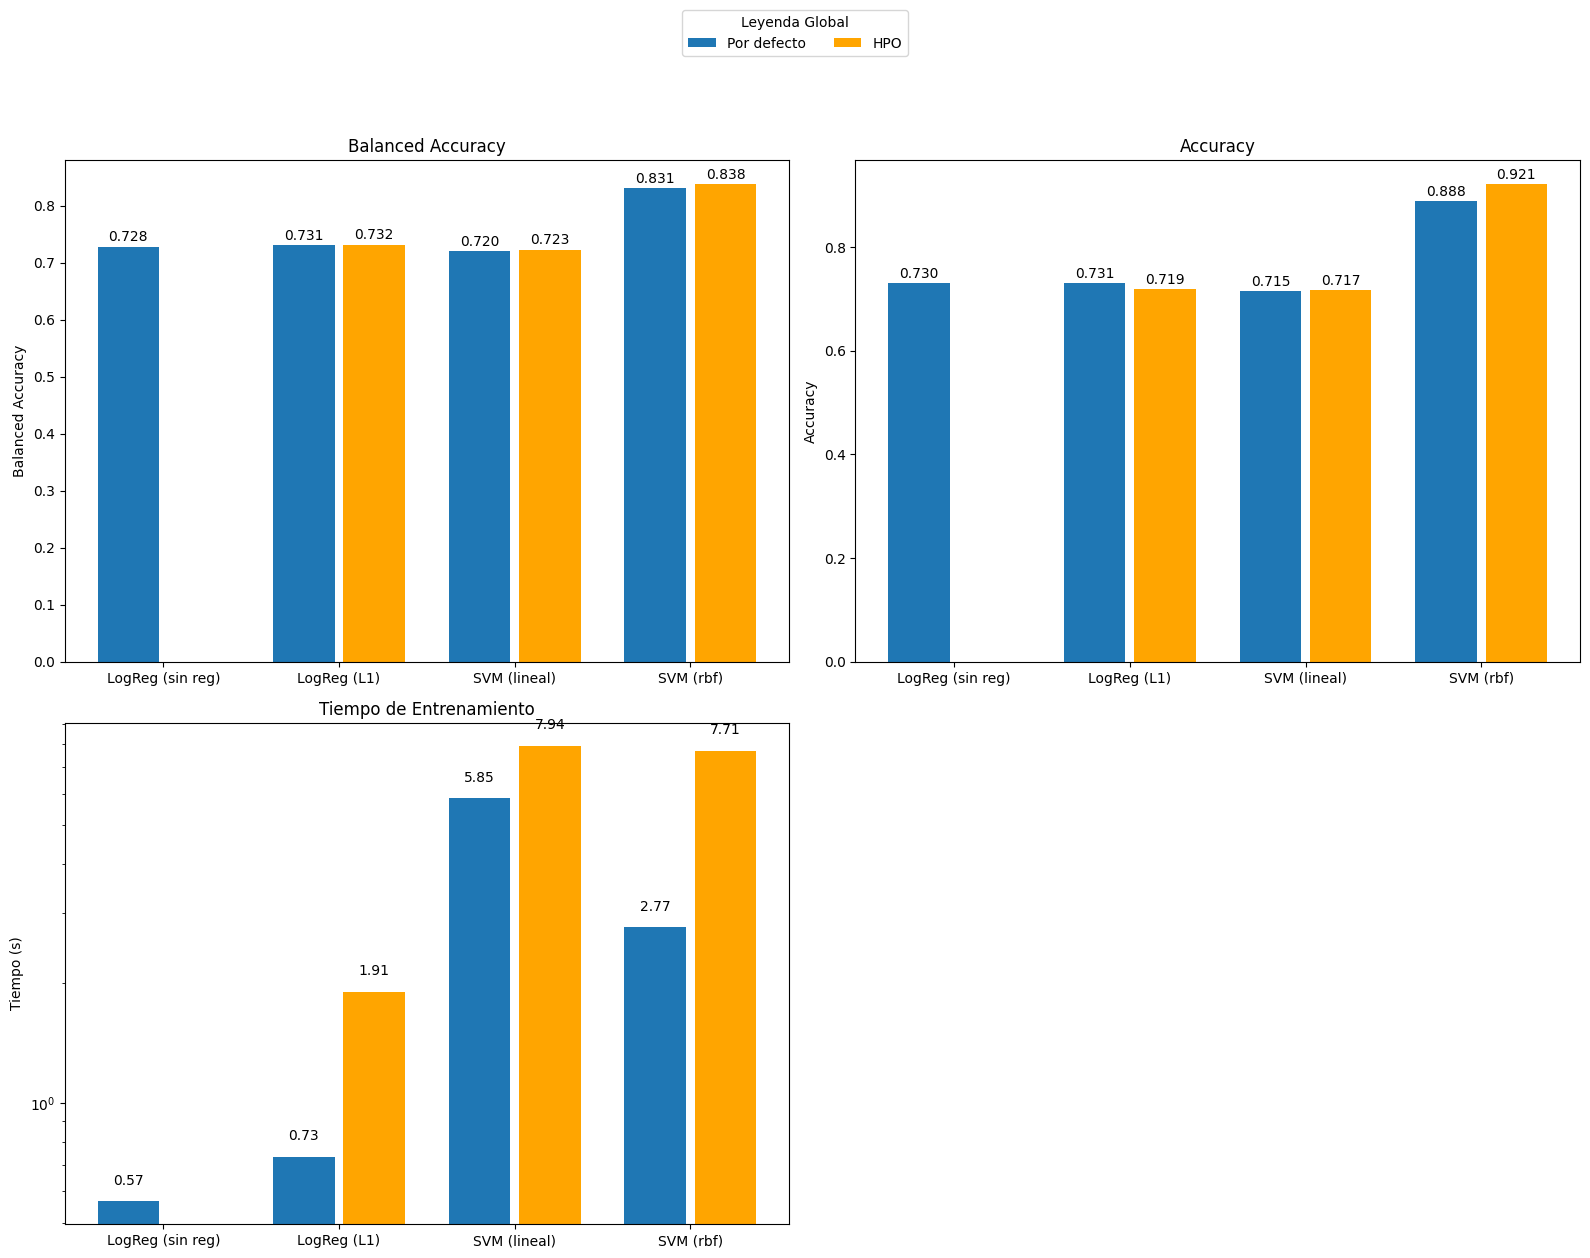

In [68]:
# Modelos
modelos = ['LogReg (sin reg)', 'LogReg (L1)', 'SVM (lineal)', 'SVM (rbf)']

# Balanced Accuracy
bal_acc_default = [bal_acc_lr_no_reg, bal_acc_lr_l1, bal_acc_svm, bal_acc_svm_rbf]
bal_acc_hpo     = [None, bal_acc_lr_l1_hpo, bal_acc_svm_hpo, bal_acc_svm_rbf_hpo]

# Accuracy
acc_default = [acc_lr_no_reg, acc_lr_l1, acc_svm, acc_svm_rbf]
acc_hpo     = [None, acc_lr_l1_hpo, acc_svm_hpo, acc_svm_rbf_hpo]

# Tiempos de entrenamiento ¡
dt_default = [lr_time, lr_time_l1, svm_time, svm_time_rbf]
dt_hpo     = [None, lr_l1_time_hpo, svm_time_hpo, svm_rbf_time_hpo]

fig, axs = plt.subplots(2, 2, figsize=(16, 12), gridspec_kw={'height_ratios': [1, 1]})

# ----------------------------------------------------------------------------------------------------------------------------------

# Balanced Accuracy
bars1 = axs[0, 0].bar(np.arange(len(modelos)) - 0.2, bal_acc_default, width=0.35, label='Por defecto', color='#1f77b4')
bars2 = axs[0, 0].bar(np.arange(len(modelos)) + 0.2, [v if v is not None else 0 for v in bal_acc_hpo], width=0.35, label='HPO', color='orange')
axs[0, 0].set_title('Balanced Accuracy')
axs[0, 0].set_ylabel('Balanced Accuracy')
axs[0, 0].set_xticks(np.arange(len(modelos)))
axs[0, 0].set_xticklabels(modelos)
for i, val in enumerate(bal_acc_default):
    axs[0, 0].text(i - 0.2, val + 0.01, f'{val:.3f}', ha='center')
for i, val in enumerate(bal_acc_hpo):
    if val is not None:
        axs[0, 0].text(i + 0.2, val + 0.01, f'{val:.3f}', ha='center')

# ----------------------------------------------------------------------------------------------------------------------------------

# Accuracy
bars1 = axs[0, 1].bar(np.arange(len(modelos)) - 0.2, acc_default, width=0.35, label='Por defecto', color='#1f77b4')
bars2 = axs[0, 1].bar(np.arange(len(modelos)) + 0.2, [v if v is not None else 0 for v in acc_hpo], width=0.35, label='HPO', color='orange')
axs[0, 1].set_title('Accuracy')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_xticks(np.arange(len(modelos)))
axs[0, 1].set_xticklabels(modelos)
for i, val in enumerate(acc_default):
    axs[0, 1].text(i - 0.2, val + 0.01, f'{val:.3f}', ha='center')
for i, val in enumerate(acc_hpo):
    if val is not None:
        axs[0, 1].text(i + 0.2, val + 0.01, f'{val:.3f}', ha='center')

# ----------------------------------------------------------------------------------------------------------------------------------

# Tiempo de entrenamiento
bars1 = axs[1, 0].bar(np.arange(len(modelos)) - 0.2, dt_default, width=0.35, label='Por defecto', color='#1f77b4')
bars2 = axs[1, 0].bar(np.arange(len(modelos)) + 0.2, [v if v is not None else 0 for v in dt_hpo], width=0.35, label='HPO', color='orange')
axs[1, 0].set_title('Tiempo de Entrenamiento')
axs[1, 0].set_ylabel('Tiempo (s)')
axs[1, 0].set_xticks(np.arange(len(modelos)))
axs[1, 0].set_xticklabels(modelos)
axs[1, 0].set_yscale('log')
for i, val in enumerate(dt_default):
    axs[1, 0].text(i - 0.2, val * 1.1, f'{val:.2f}', ha='center')
for i, val in enumerate(dt_hpo):
    if val is not None:
        axs[1, 0].text(i + 0.2, val * 1.1, f'{val:.2f}', ha='center')

# ----------------------------------------------------------------------------------------------------------------------------------

fig.delaxes(axs[1, 1])
fig.legend(['Por defecto', 'HPO'], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, title="Leyenda Global")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Como se puede observar, los modelos lineales una balanced accuracy alrededor del 0.74, un resultado notablemente inferior a los resultados vistos por los modelos KNN (~0.82), Árbol de Decisión (~0.81) y Random Forest (~0.80).
Los modelos lineales y SVM con kernel lineal son menos adecuados para este problema, probablemente por su incapacidad para capturar relaciones no lineales en los datos. Por tanto, no son la mejor opción en este caso y no serán utilizados para la predicción del abandono de empleados.7

El modelo SVM con kernel RFB en cambio, ha logrado una balanced accuracy de ~0.83, lo que lo convierte en el mejor modelo de todos los modelos lineales y SVMs. Sin embargo, su coste computacional es significativamente más alto que el de los otros modelos (como knn con HPO), lo que me hace dudar de su viabilidad en un entorno real.


#### Relevancia de los atributos

Una de las ventajas de utilizar modelos lineales como la regresión logística o el SVM con kernel lineal es que permiten interpretar de forma directa la relevancia de cada variable en la predicción. Estos modelos aprenden un vector de coeficientes, uno por cada atributo, que indica el peso que tiene esa variable en la decisión final.

- Un **coeficiente positivo** indica que el atributo **aumenta la probabilidad de abandono**.
- Un **coeficiente negativo** indica que el atributo **reduce la probabilidad de abandono**.
- Cuanto **mayor es el valor absoluto** del coeficiente, **más importante** es esa variable en la predicción.


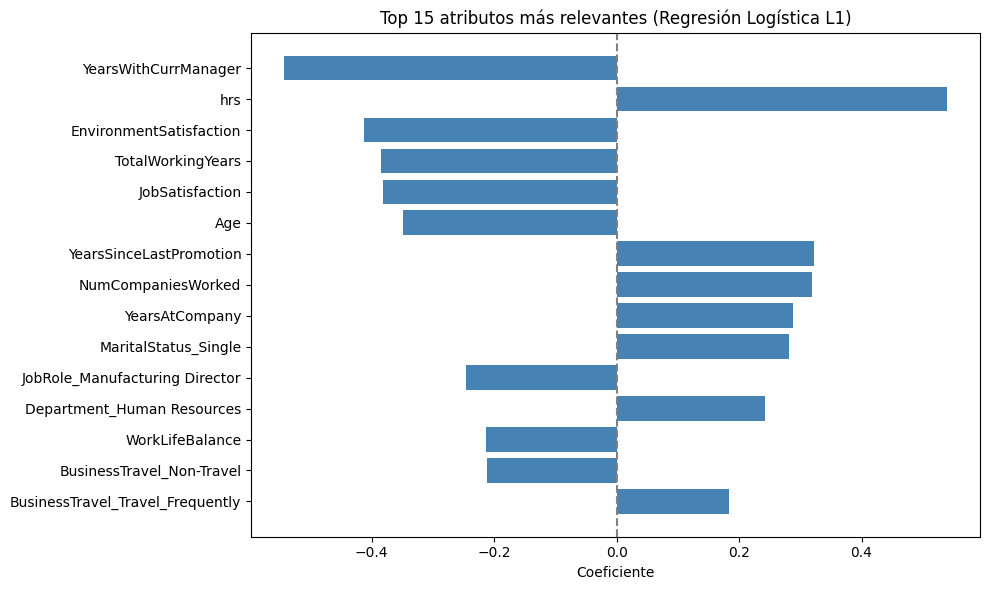

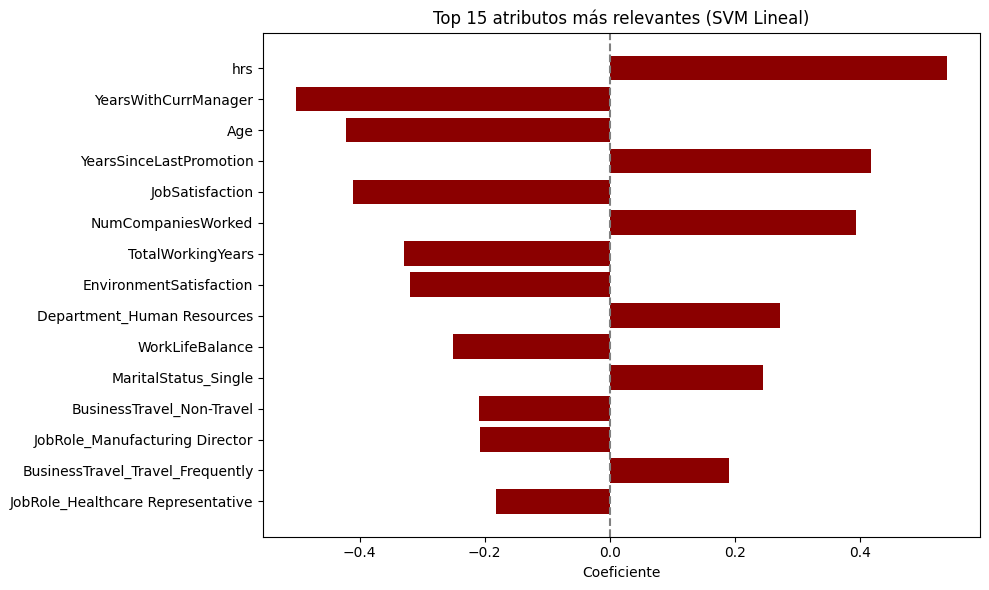

In [69]:
# Obtener nombres de variables tras el preprocesamiento
feature_names = preprocessor.transformers_[0][2] + list(
    preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_columns)
)

# Coeficientes del modelo de Regresión Logística L1 y SVM
coefs = best_lr_l1.named_steps['lr'].coef_.flatten()
svm_coefs = best_svm.named_steps['svm'].coef_.flatten()

# Crear los DataFrames ordenados por importancia
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coefs,
    'abs_coef': np.abs(coefs)
}).sort_values(by='abs_coef', ascending=False)

svm_coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': svm_coefs,
    'abs_coef': np.abs(svm_coefs)
}).sort_values(by='abs_coef', ascending=False)

# Mostrar los 15 coeficientes más relevantes
top_n = 15

# Gráfico para Regresión Logística L1
plt.figure(figsize=(10, 6))
plt.barh(coef_df['feature'].head(top_n), coef_df['coef'].head(top_n), color='steelblue')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Coeficiente')
plt.title(f'Top {top_n} atributos más relevantes (Regresión Logística L1)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Gráfico para SVM Lineal
plt.figure(figsize=(10, 6))
plt.barh(svm_coef_df['feature'].head(top_n), svm_coef_df['coef'].head(top_n), color='darkred')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Coeficiente')
plt.title(f'Top {top_n} atributos más relevantes (SVM Lineal)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Como se puede observar, LogisticRegression con regularización L1 tiende a seleccionar automáticamente los atributos más informativos, dejando fuera aquellos menos relevantes (coeficiente = 0), lo que facilita su interpretación. Destacan como factores protectores frente al abandono ('Attrition') variables como **YearsWithCurrentManager**, **EnviromentSatisfaction** o **JobSatisfaction**, con coeficientes negativos, asociados a una menor probabilidad de abandono. En cambio, atributos como **hrs** aparecen con coeficientes positivos, sugiriendo que trabajar más horas está relacionado con una mayor intención de abandonar la empresa.

En SVM con kernel lineal se observan patrones similares. Variables como **hrs**, **JobSatisfaction**, **YearsWithCurrManager** y **EnvironmentSatisfaction** también aparecen como relevantes, lo que refuerza su importancia en la predicción del abandono. Sin embargo, surgen nuevas variables como **YearsSinceLastPromotion** y **WorkLifeBalance**, lo que sugiere que también podrían tener un impacto importante en la predicción de 'Attrition'.

## Resultados y modelo final

### Mejor modelo 

Tras evaluar distintas alternativas mediante validación cruzada (evaluación inner), el modelo que ha ofrecido el mejor equilibrio entre rendimiento y coste computacional ha sido **KNN con hiperparámetros optimizados**. Este modelo ha alcanzado la mayor balanced accuracy entre todas las opciones consideradas, mostrando una buena capacidad para distinguir entre ambas clases en un problema con desbalance.

Además, presenta una estructura relativamente simple y un tiempo de entrenamiento razonable en comparación con modelos más complejos como Random Forest, lo que refuerza que sea escogido como modelo final.

### Estimación del rendimiento futuro (outer evaluation)

En este paso, evaluaré el rendimiento del modelo final en un conjunto de datos completamente nuevo (test set) que no ha sido utilizado durante el entrenamiento ni la validación. Esto me permitirá estimar cómo se comportará el modelo en situaciones reales y si es capaz de generalizar bien a nuevos datos.


,Balanced_accuracy,accuracy,Tiempo (s),TPR,TNR
Modelo Final (KNN con HPO),0.879755,0.939796,0.078725,0.791139,0.96837


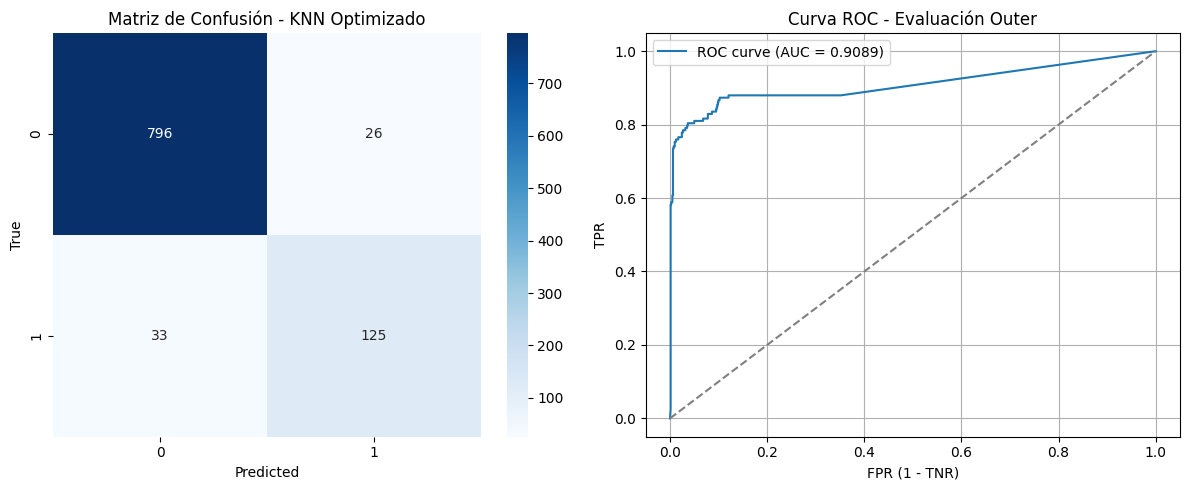

In [70]:
# Medir el tiempo de entrenamiento y evaluación del modelo final
start_time_final = time.time()

# Entrenar modelo final con los mejores hiperparámetros encontrados
modelo_final = grid_knn.best_estimator_
modelo_final.fit(X_train, y_train)

# Evaluar el modelo final en el conjunto de prueba
y_pred_outer = modelo_final.predict(X_test)

# Medir el tiempo de evaluación
end_time_final = time.time()

# Calcular métricas
bal_acc_final = balanced_accuracy_score(y_test, y_pred_outer)
acc_final = accuracy_score(y_test, y_pred_outer)
cm_matrix_final = confusion_matrix(y_test, y_pred_outer)

# Calcular TPR y TNR
TPR = cm_matrix_final[1,1] / (cm_matrix_final[1,1] + cm_matrix_final[1,0])
TNR = cm_matrix_final[0,0] / (cm_matrix_final[0,0] + cm_matrix_final[0,1])

# Tiempos de entrenamiento y evaluación
tiempo_total_final = end_time_final - start_time_final

# Crear un DataFrame con las métricas
metrics_df = pd.DataFrame({
    "Balanced_accuracy": [bal_acc_final],
    "accuracy": [acc_final],
    "Tiempo (s)": [tiempo_total_final],
    "TPR": [TPR],
    "TNR": [TNR],
}, index=["Modelo Final (KNN con HPO)"])

# Mostrar el DataFrame
display(metrics_df)

# Crear subplots para la matriz de confusión y la curva ROC
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# Matriz de confusión
sns.heatmap(cm_matrix_final, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=[0, 1], yticklabels=[0, 1], ax=axes[0])
axes[0].set_title('Matriz de Confusión - KNN Optimizado')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Curva ROC
y_proba = modelo_final.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set_title('Curva ROC - Evaluación Outer')
axes[1].set_xlabel('FPR (1 - TNR)')
axes[1].set_ylabel('TPR')
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()

Tras realizar la evaluación del modelo final en el conjunto de prueba, se puede observar lo siguiente: 

- El **balanced accuracy** del modelo ha sido de ~0.88, lo que indica un buen rendimiento en la clasificación de ambas clases, tanto en la detección de empleados que abandonan (en menor medida) como en la identificación de aquellos que no lo hacen.

- El **accuracy** del modelo acierta en casi un 94% de los casos, aunque esto resulta un poco engañoso debido al desbalance en la variable 'Attrition' y por ello es una métrica que no he tenido muy en cuenta en la evaluación de los modelos.

- El modelo identifica correctamente un 79% de los empleados que abandonan **(TPR)** y a un 97% de los empleados que no abandonan **(TNR)**. Esto permite que la empresa pueda anticiparse a las bajas de los empleados minimizando falsos positivos (es decir, no alerta innecesariamente sobre empleados que no se van a ir).

- La **curva ROC** muestra la capacidad del modelo para distinguir entre empleados que abandonan y los que no, en diferentes umbrales de decisión. El área bajo la curva 'AUC' es de ~0.91, lo que indica una excelente capacidad de discriminación. En términos prácticos, si se selecciona al azar a un empleado que ha abandonado la empresa y a otro que no, el modelo tiene un 91% de probabilidad de asignar una puntuación más alta al que sí ha abandonado

### Entrenamiento y guardado del modelo final

Una vez seleccionada la mejor alternativa (KNN con HPO) y estimado su rendimiento futuro mediante la evaluación outer, voy a proceder a entrenar el modelo final. Este modelo se entrena utilizando todo el conjunto de entrenamiento (X_train, y_train), ya que el conjunto de test solo se utiliza para evaluar el rendimiento y no se emplea para aprender. El modelo final incluye el pipeline completo (imputación, escalado y modelo KNN) y los mejores hiperparámetros encontrados con GridSearchCV.

Una vez entrenado, el modelo se guarda en un fichero llamado modelo_final.pkl, que me permitirá reutilizarlo sin necesidad de reentrenarlo.


In [71]:
# Entrenar el modelo final con todos los datos de entrenamiento
modelo_final = grid_knn.best_estimator_
modelo_final.fit(X_train, y_train)

# Guardar el modelo en un archivo .pkl
joblib.dump(modelo_final, 'modelo_final.pkl')

print("Modelo final entrenado y guardado como 'modelo_final.pkl'")

Modelo final entrenado y guardado como 'modelo_final.pkl'


## Tarea de elección abierta
Además de cumplir con todos los requisitos establecidos en esta práctica (evaluar modelos básicos, avanzados y realizar la validación interna y externa), he decidido enriquecer el análisis incluyendo evaluaciones adicionales, como el modelo **Random Forest**, que no era obligatorio pero que consideré para ampliar las comparaciones.

Como tarea de elección abierta, he optado por evaluar la robustez del modelo final seleccionado (KNN optimizado) frente a perturbaciones aleatorias en los datos. Esto simula escenarios reales en los que los datos de entrada pueden contener ruido debido a errores de medición, inconsistencias o cambios naturales en las condiciones del entorno.

He escogido esto como tarea adicional ya que me parece bastante interesante ver cómo el modelo se comporta ante datos distorsionados y si es capaz de mantener un rendimiento alto a pesar de estas perturbaciones.

### Ruido en los datos
Voy a comenzar simulando perturbaciones aleatorias en los datos de prueba (X_test). Para ello, voy a añadir ruido gaussiano (distribución normal) a las características del conjunto de prueba.

In [72]:
# Introducir ruido gaussiano en los datos de prueba
np.random.seed(SEED)  
noise_level = 0.1  
X_test_noisy = X_test + noise_level * np.random.normal(size=X_test.shape)

# Para no tener valores con ruido fuera del rango original
X_test_noisy = np.clip(X_test_noisy, X_test.min().min(), X_test.max().max())

### Evaluación del modelo con ruido
Una vez generados los datos con ruido, voy a usar el modelo final previamente entrenado para realizar predicciones sobre este conjunto ruidoso. Posteriormente, calcularé las métricas de rendimiento usadas durante toda la práctica para analizar cómo afecta el ruido al rendimiento del modelo.

In [73]:
# Predecir con los datos ruidosos
y_pred_noisy = modelo_final.predict(X_test_noisy)

# Calcular métricas de rendimiento
bal_acc_noisy = balanced_accuracy_score(y_test, y_pred_noisy)
acc_noisy = accuracy_score(y_test, y_pred_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# DataFrame con las métricas originales y con ruido
metrics_comparison = pd.DataFrame({
    "Balanced Accuracy": [bal_acc_final, bal_acc_noisy],
    "Accuracy": [acc_final, acc_noisy],
}, index=["Test set sin ruido", "Test set con ruido"])

display(metrics_comparison)

,Balanced Accuracy,Accuracy
Test set sin ruido,0.879755,0.939796
Test set con ruido,0.735648,0.886735


### Representación gráfica de los resultados obtenidos


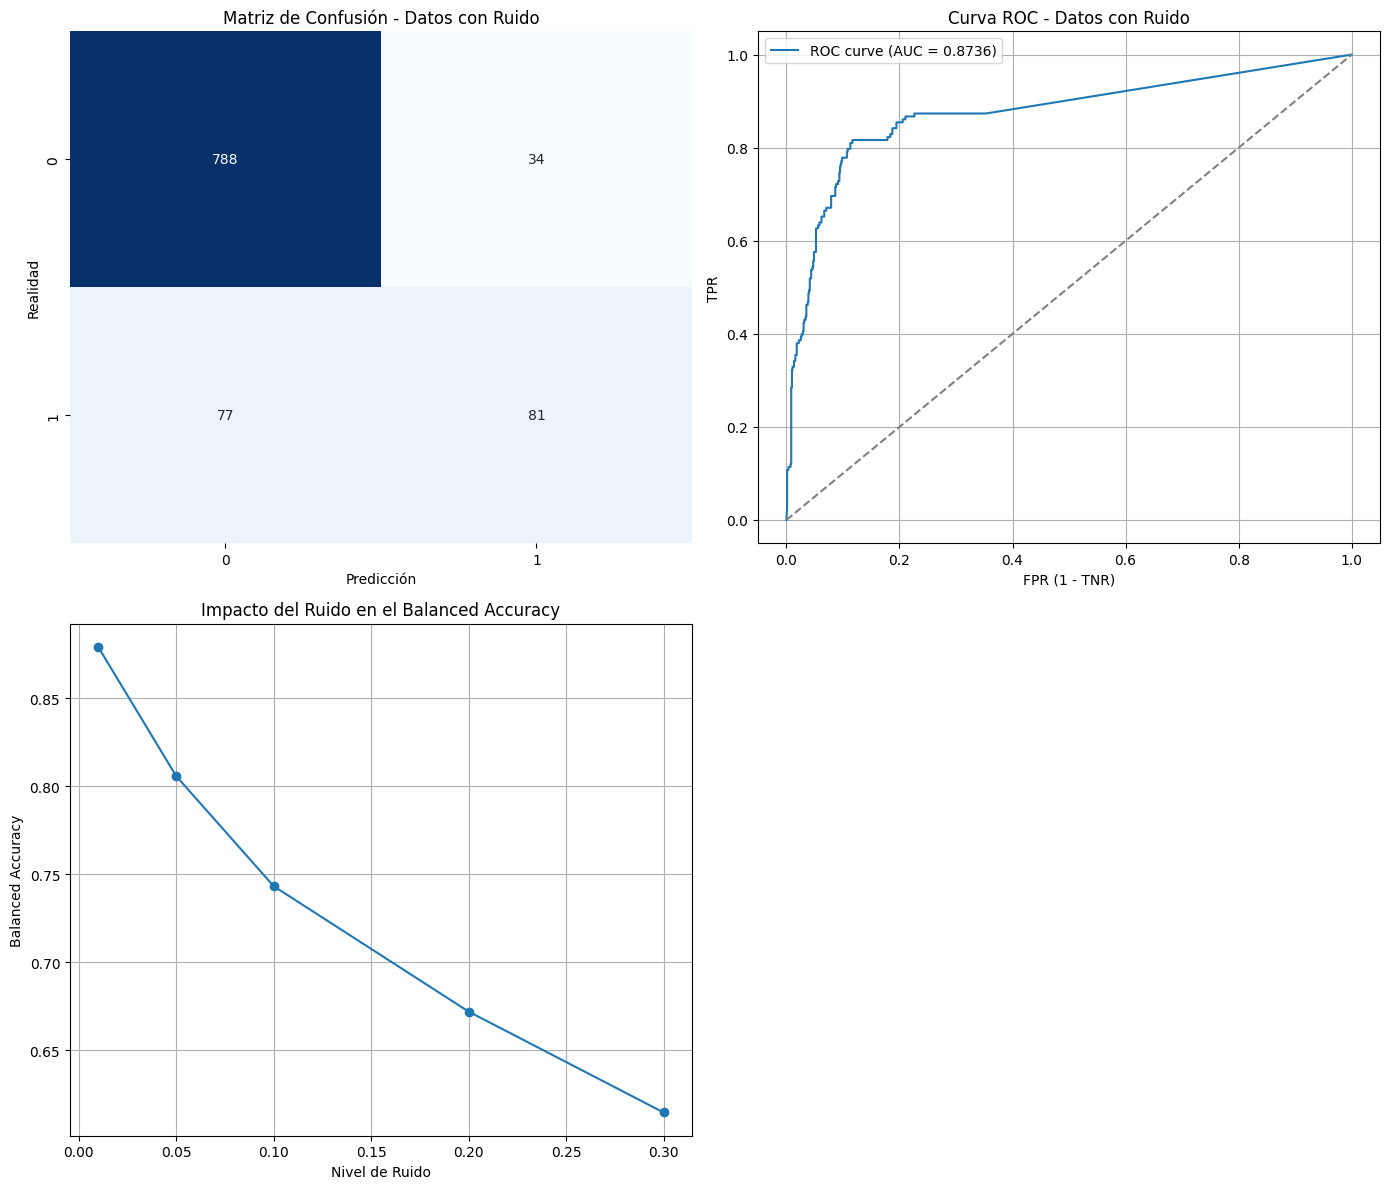

In [74]:
# Diseño de 2x2 (filas x columnas)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Matriz de confusión con ruido
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0, 0])
axes[0, 0].set_title("Matriz de Confusión - Datos con Ruido")
axes[0, 0].set_xlabel("Predicción")
axes[0, 0].set_ylabel("Realidad")

# Curva ROC
y_proba_noisy = modelo_final.predict_proba(X_test_noisy)[:, 1]  # Usar predict_proba para KNN
fpr, tpr, _ = roc_curve(y_test, y_proba_noisy)
roc_auc = auc(fpr, tpr)

axes[0, 1].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0, 1].set_title("Curva ROC - Datos con Ruido")
axes[0, 1].set_xlabel("FPR (1 - TNR)")
axes[0, 1].set_ylabel("TPR")
axes[0, 1].legend()
axes[0, 1].grid(True)

# Diferentes niveles de ruido
noise_levels = [0.01, 0.05, 0.1, 0.2, 0.3]
results = []

for noise in noise_levels:
    # Introducir ruido gaussiano en los datos de prueba
    X_test_noisy = X_test + noise * np.random.normal(size=X_test.shape)
    X_test_noisy = np.clip(X_test_noisy, X_test.min().min(), X_test.max().max())
    
    # Predecir con los datos ruidosos
    y_pred_noisy = modelo_final.predict(X_test_noisy)
    
    # Calcular métricas
    bal_acc_noisy = balanced_accuracy_score(y_test, y_pred_noisy)
    results.append((noise, bal_acc_noisy))

results_df = pd.DataFrame(results, columns=["Noise Level", "Balanced Accuracy"])
axes[1, 0].plot(results_df["Noise Level"], results_df["Balanced Accuracy"], marker='o')
axes[1, 0].set_title("Impacto del Ruido en el Balanced Accuracy")
axes[1, 0].set_xlabel("Nivel de Ruido")
axes[1, 0].set_ylabel("Balanced Accuracy")
axes[1, 0].grid(True)
axes[1, 1].axis('off')
plt.tight_layout()
plt.show()

### Conclusiones de la tarea de elección abierta

- **Comparación de resultados**:
    
    Al comparar el rendimiento del modelo en el conjunto de prueba sin ruido y con ruido se observa una disminución en el balanced accuracy de 0.88 a 0.74 y en la accuracy de 0.94 a 0.89. Esto indica que el ruido afecta la capacidad del modelo para clasificar correctamente, especialmente de manera equilibrada entre las clases. 

- **Impacto del ruido en el rendimiento del modelo**:
    
    A medida que aumenta el nivel de ruido en los datos, se observa una disminución progresiva en el balanced accuracy del modelo. Esto indica que el modelo es sensible a las perturbaciones en las características, lo cual es esperable dado que el ruido puede alterar las relaciones entre las variables y las etiquetas.
    Sin embargo, incluso con niveles moderados de ruido, el modelo mantiene un rendimiento aceptable, lo que sugiere una cierta robustez frente a pequeñas perturbaciones.

- **Matriz de confusión**:
    
    La matriz de confusión para los datos ruidosos muestra un aumento en los errores de clasificación, especialmente en la clase minoritaria. Esto refleja que el ruido afecta más a la capacidad del modelo para identificar correctamente las instancias de esta clase, lo que podría ser un área de mejora en futuros ajustes del modelo.

- **Curva ROC y AUC**:
    
    La curva ROC para los datos ruidosos sigue mostrando un buen desempeño general, aunque el área bajo la curva (AUC) disminuye ligeramente en comparación con los datos originales. Esto confirma que el modelo sigue siendo capaz de distinguir entre las clases, pero con menor precisión a medida que el ruido aumenta.

- **Relación entre ruido y rendimiento**:

    El análisis del impacto del ruido en el balanced accuracy revela que el modelo es más robusto frente a niveles bajos de ruido (por ejemplo, 0.01 o 0.05), pero su rendimiento se degrada significativamente con niveles más altos (por ejemplo, 0.2 o 0.3). Esto sugiere que el modelo podría beneficiarse de técnicas adicionales de regularización o preprocesamiento para manejar mejor escenarios con datos más ruidosos.

## Uso de ChatGPT en la practica

He empleado ChatGPT principalmente para ayudarme con la redacción de textos explicativos, el ajuste de alguna representación gráfica y la resolución de errores durante el desarrollo del proyecto.

Un uso concreto ha sido, por ejemplo, durante la evaluación de los modelos básicos (KNN, Árbol de Decisión y Random Forest). En esa parte, tuve dudas al comparar los resultados obtenidos antes y después del ajuste de hiperparámetros, así como en la representación visual de los resultados. ChatGPT me ayudó a organizar las gráficas de forma clara, para que visualmente se pudiera apreciar la relación rendimiento-coste computacional entre los distintos modelos.

También me fue útil al depurar un error relacionado con el preprocesamiento del dataset de 'competition', que me impedía generar las predicciones finales al no contar con las mismas columnas que el train set. Gracias a sus indicaciones, consegui darme cuenta de cual era el problema y como solucionarlo.